In [1]:
%matplotlib inline


# Ses Yeniden Örnekleme

Bu öğretici, torchaudio'nun yeniden örnekleme API'sinin nasıl kullanılacağını gösterir.


In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.1+cu116
0.13.1+cu116


## Hazırlık

İlk önce modülleri içe aktarıyoruz ve yardımcı işlevleri tanımlıyoruz.

Aşağıda verilen paketi yükleyelim.

!pip install librosa</p></div>



In [3]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import math
import time

import librosa
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Frekansları günlük ölçeğinde eşit aralıklarla alın [0, max_sweep_rate // 2],
        offset, negatif sonsuzdan kaçınmak için kullanılır `log(offset + x)`.
    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Verilen frekansın _get_log_freq tarafından verildiği zamanı bulun"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Taramayı oluşturmak için kullanılan orijinal örnekleme oranı göz önüne alındığında,
    # log ölçekli ana frekans değerlerinin düştüğü x ekseni değerini bulun
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Orijinal Sinyal Frekansı (Hz, log scale)")
    axis.set_ylabel("Dalga Formu Frekansı (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)
    plt.show(block=True)

## Yeniden Örneklemeye Genel Bakış

Bir ses dalga biçimini bir frekanstan diğerine yeniden örneklemek için şunu kullanabilirsiniz:
`torchaudio.transforms.Resample` veya
`torchaudio.functional.resample`.
``transforms.Resample`` yeniden örnekleme için kullanılan çekirdeği önceden hesaplar ve önbelleğe alır,
``functional.resample`` bunu anında hesaplarken,
``torchaudio.transforms.Resample``, yeniden örnekleme sırasında aynı parametreleri kullanan çoklu dalga biçimlerinde hızlanmaya neden olur.
Her iki yeniden örnekleme yöntemi de bandlimited sinc
interpolation] (https://ccrma.stanford.edu/~jos/resample/) keyfi zaman adımlarında sinyal değerlerini hesaplamak için evrişim adımlarını içerir. Bundan dolayı modelimizin performansının geliştirmek için GPU kullanabiliriz.
Veri yükleme gibi birden çok alt süreçte yeniden örneklemeyi kullanırken sisteminizin verimli bir şekilde işleyebileceğinden daha fazla iş parçacığını oluşturabiliriz . `torch.set_num_threads(1)` ayarı bu durumda bize yardımcı olabilir.
Aşağıdaki spektrogramlar, sinyalin frekans temsilini gösterir,
burada x ekseni orijinalin frekansına karşılık gelir
(dalga formu (log ölçeğinde)), y ekseni ise frekansı
çizilen dalga formu ve renk yoğunluğunu gösterir.




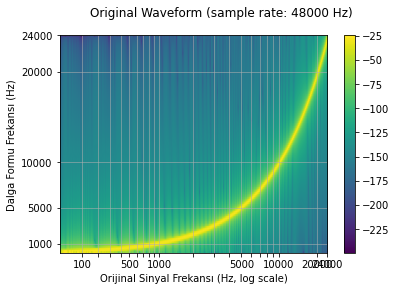

In [5]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

Şimdi onu yeniden örnekliyoruz (alt örneklendiriyoruz).




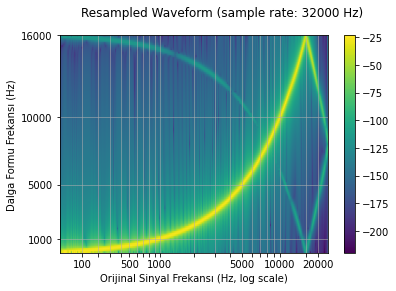

In [6]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

## Yeniden örnekleme kalitesini parametrelerle kontrol etme

### Lowpass filter width

Enterpolasyon için kullanılan filtre sonsuz genişlediğinde olduğundan dolayı
genişliğini kontrol etmek için ``lowpass_filter_width`` parametresi kullanılır.
Daha büyük bir "lowpass_filter_width" kullanma
daha keskin, daha hassas bir filtre sağlar, ancak hesaplama açısından daha
masraflıdır.




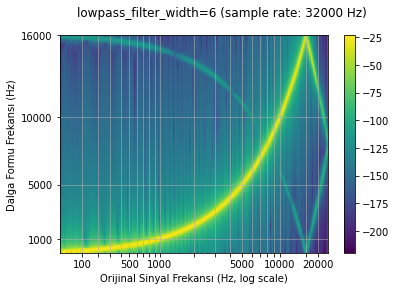

In [7]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

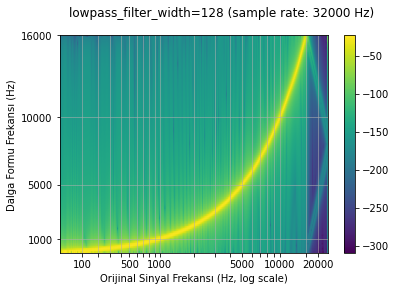

In [8]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

### Rolloff

Nyquist'in bir kesri olarak temsil edilir ve
belirli bir değerle temsil edilebilen maksimum frekans olan frekans
sonlu örnekleme oranı ``rolloff`` alçak geçiren filtre kesmesini belirler.Frekanslar değiştiğinde gerçekleşen örtüşme derecesini kontrol eder.
Nyquist'ten daha yüksek frekanslar daha düşük frekanslarla eşlenir. Daha düşük bir rolloff demek örtüşme miktarını azaltacaktır.




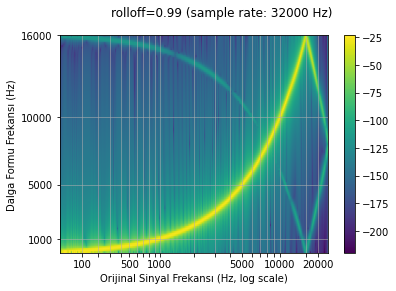

In [9]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

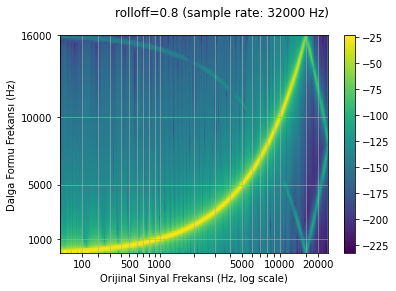

In [10]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

### Window function

Varsayılan olarak ``torchaudio``nun yeniden örneği, Hann window filter kullanır.Ayrıca Kaiser window destekler. `resampling_method` parametresi kullanılarak kontrol edilir.




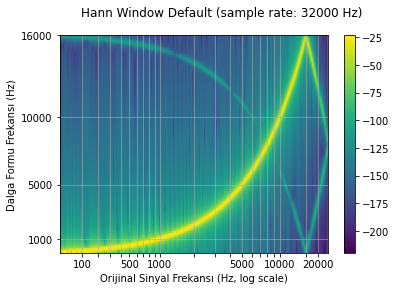

In [11]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

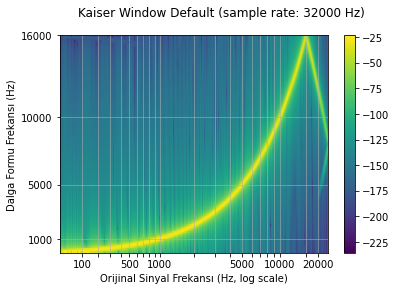

In [12]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

## librosa paketi vs diğerleri

``torchaudio``nun yeniden örnekleme işlevi şuna benzer sonuçlar üretmek için kullanılabilir:
librosa (resampy) kaiser penceresinin yeniden örneklemesi, ancak biraz gürültülü



In [13]:
sample_rate = 48000
resample_rate = 32000

### kaiser_best




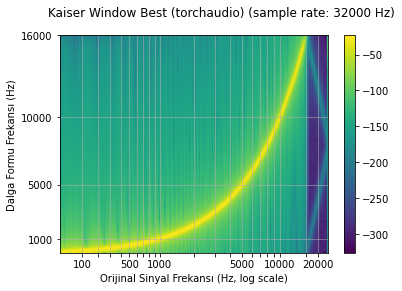

In [14]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

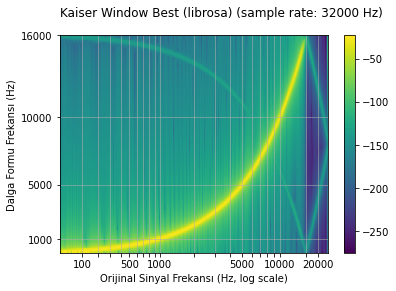

In [15]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_best")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

In [16]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio ve librosa kaiser best MSE:", mse)

torchaudio ve librosa kaiser best MSE: 0.0013004566355607607


### kaiser_fast




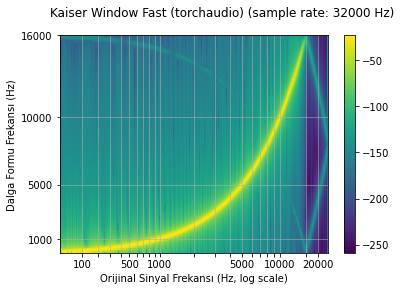

In [17]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="kaiser_window",
    beta=8.555504641634386,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

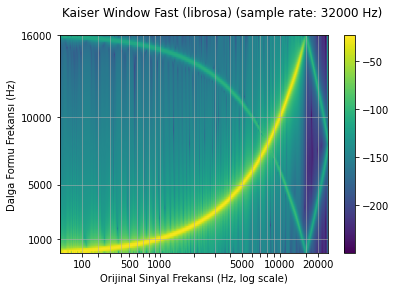

In [18]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_fast")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Fast (librosa)")

In [19]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio ve librosa kaiser fast MSE:", mse)

torchaudio ve librosa kaiser fast MSE: 0.00025679812518532053


## Performans Kıyaslaması

`lowpass_filter_width`, daha büyük bir yeniden örnekleme çekirdeği sağlar,
   ve bu nedenle hem çekirdek hesaplama için hesaplama süresini artırır
`kaiser_window` kullanılması, varsayılandan daha uzun hesaplama sürelerine neden olur
`sinc_interpolation` çünkü ara değeri hesaplamak daha karmaşıktır
pencere değerleri - örnekleme ve yeniden örnekleme oranı arasında büyük bir GCD ortaya çıkar (daha küçük bir çekirdeğe ve daha hızlı çekirdek hesaplamasına izin veren bir basitleştirmede)



In [20]:
def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interpolation",
    beta=None,
    librosa_type=None,
    iters=5,
):
    if method == "functional":
        begin = time.monotonic()
        for _ in range(iters):
            F.resample(
                waveform,
                sample_rate,
                resample_rate,
                lowpass_filter_width=lowpass_filter_width,
                rolloff=rolloff,
                resampling_method=resampling_method,
            )
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "transforms":
        resampler = T.Resample(
            sample_rate,
            resample_rate,
            lowpass_filter_width=lowpass_filter_width,
            rolloff=rolloff,
            resampling_method=resampling_method,
            dtype=waveform.dtype,
        )
        begin = time.monotonic()
        for _ in range(iters):
            resampler(waveform)
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "librosa":
        waveform_np = waveform.squeeze().numpy()
        begin = time.monotonic()
        for _ in range(iters):
            librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=resample_rate, res_type=librosa_type)
        elapsed = time.monotonic() - begin
        return elapsed / iters

In [21]:
configs = {
    "downsample (48 -> 44.1 kHz)": [48000, 44100],
    "downsample (16 -> 8 kHz)": [16000, 8000],
    "upsample (44.1 -> 48 kHz)": [44100, 48000],
    "upsample (8 -> 16 kHz)": [8000, 16000],
}

for label in configs:
    times, rows = [], []
    sample_rate = configs[label][0]
    resample_rate = configs[label][1]
    waveform = get_sine_sweep(sample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_best")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_best")

    # kaiser fast
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_fast")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    df.columns = pd.MultiIndex.from_product([[f"{label} time (ms)"], df.columns])

    print(f"torchaudio: {torchaudio.__version__}")
    print(f"librosa: {librosa.__version__}")
    display(df.round(2))

torchaudio: 0.13.1+cu116
librosa: 0.8.1


downsample (48 -> 44.1 kHz) time (ms)                      
                                              librosa functional transforms
sinc (width 64)                                   NaN       4.41       1.43
sinc (width 16)                                   NaN       1.69       1.31
kaiser_best                                     42.07       5.84       1.49
kaiser_fast                                     13.36       3.96       0.97

torchaudio: 0.13.1+cu116
librosa: 0.8.1


downsample (16 -> 8 kHz) time (ms)                      
                                           librosa functional transforms
sinc (width 64)                                NaN       8.71       7.65
sinc (width 16)                                NaN       1.75       1.38
kaiser_best                                  10.33       6.65       6.03
kaiser_fast                                   3.86       2.09       1.61

torchaudio: 0.13.1+cu116
librosa: 0.8.1


upsample (44.1 -> 48 kHz) time (ms)                      
                                            librosa functional transforms
sinc (width 64)                                 NaN       3.40       1.44
sinc (width 16)                                 NaN       1.66       0.93
kaiser_best                                   36.65       6.92       1.55
kaiser_fast                                   12.01       4.17       1.02

torchaudio: 0.13.1+cu116
librosa: 0.8.1


upsample (8 -> 16 kHz) time (ms)                      
                                         librosa functional transforms
sinc (width 64)                              NaN       5.43       2.06
sinc (width 16)                              NaN       0.66       0.37
kaiser_best                                 9.98       3.86       2.07
kaiser_fast                                 4.96       0.95       0.41